In [1]:
import xarray as xr
from pathlib import Path
import torch
from network_def import NN
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

In [2]:
DATA_DIR = "/nfs/home/lverho/research_data/GLP/synthetic_data/"

In [3]:
ds = xr.open_dataset(DATA_DIR + 'crps_test.nc')

In [4]:
ds

<xarray.Dataset>
Dimensions:  (idx: 10000000)
Dimensions without coordinates: idx
Data variables:
    mean     (idx) float64 ...
    sig      (idx) float64 ...
    target   (idx) float64 ...

In [17]:
# Create custom dataset method
class SynthDataset(Dataset):
    def __init__(self, full_ds, start_idx=None, end_idx=None, transform=None, target_transform=None):
        self.full_ds = full_ds.isel(idx=slice(start_idx, end_idx))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.full_ds.idx.shape[0]

    def __getitem__(self, idx):
        sample_ds = self.full_ds.isel(idx=idx)
        input = torch.unsqueeze(torch.tensor([sample_ds['mean'].item(), sample_ds['sig'].item()]), 0)
        label = torch.reshape(torch.tensor(sample_ds['target'].item()), (1, 1))
        if self.transform:
            input = self.transform(input)
        if self.target_transform:
            label = self.target_transform(label)
        return input, label


ds = xr.load_dataset(DATA_DIR + 'crps_test.nc')

train_ds = SynthDataset(ds, end_idx=int(1e6))
valid_ds = SynthDataset(ds, start_idx=int(1e6), end_idx=int(1.5e6))

batch_size = 32
train_dataloader = DataLoader(train_ds, num_workers=4, batch_size=batch_size)
valid_dataloader = DataLoader(valid_ds, num_workers=4, batch_size=batch_size)

In [18]:
model = NN()
model.load_state_dict(torch.load('./saved_models/crps_test.pt', map_location=torch.device('cpu')))
model.eval()

NN(
  (hidden_layers): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=100, bias=True)
  )
)

In [29]:
test_inputs = next(iter(valid_dataloader))
test_inputs[0][12]

tensor([[8.0352, 0.6850]])

In [30]:
with torch.no_grad():
    test_res = model(test_inputs[0][12])

(array([ 1.,  0.,  3.,  7., 14., 13., 20., 15., 21.,  6.]),
 array([5.58818054, 5.97302961, 6.35787868, 6.74272823, 7.1275773 ,
        7.51242638, 7.89727545, 8.28212452, 8.66697407, 9.05182266,
        9.43667221]),
 <BarContainer object of 10 artists>)

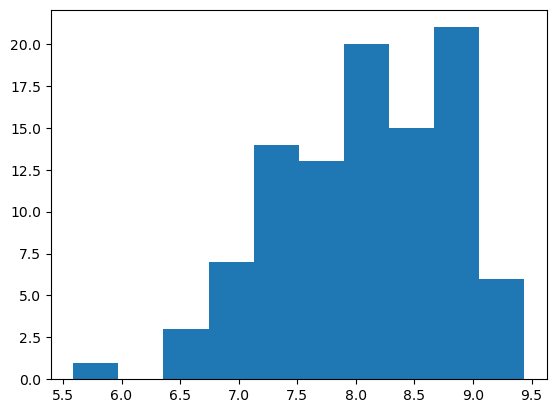

In [31]:
plt.hist(test_res)

In [32]:
test_res.mean()

tensor(8.0766)

In [33]:
test_res.std()

tensor(0.7333)

In [34]:
test_res.shape

torch.Size([1, 100])

In [35]:
test_inputs[1][12]

tensor([[7.9009]])